# 법률 문서 기반 검색 에이전트 개발

> 목표 : Adaptive RAG, Corrective RAG 구현

## 환경 설정

In [1]:
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv()

True

In [2]:
from pprint import pprint

In [3]:
from typing import TypedDict, Annotated, Dict, List, Any, Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langgraph.types import Send, Command
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image
import operator

In [4]:
from langfuse.langchain import CallbackHandler

# 콜백 핸들러 생성
callback_handler = CallbackHandler()

## 1. 인덱싱

In [5]:
import os
from glob import glob

# 파일 목록 확인
pdf_files = glob(os.path.join('data', '*.pdf'))
pdf_files

['data/labor_law.pdf',
 'data/personal_info_law.pdf',
 'data/housing_leasing_law.pdf']

### 1\) 법령 문서 가공 함수 정의

In [6]:
import re
from typing import List, Dict
from langchain_core.documents import Document


def clean_document(docs: List[Document], text_for_delete: str) -> str:
    return "\n".join([re.sub(text_for_delete, "", p.page_content).strip() for p in docs])

def extract_preamble(text: str) -> str:
    """
    법령 서문을 추출하는 함수입니다.
    """
    preamble_pattern = r'^(.*?)(?=제1장|제1조)'
    preamble = re.search(preamble_pattern, text, re.DOTALL)

    if preamble:
        return preamble.group(1).strip()
    return ''

def extract_body(text: str) -> Dict[str, List[str]]:
    """
    법령 본문(서문/부칙 제외)을 추출하는 함수입니다.
    """
    chunks = {}
    # ✅ 정규표현식 개선
    chapter_pattern = r'(제\d+장\s+.+?)\n((?:제\d+조(?:의\d+)?(?:\(\w+\))?.*?)(?=제\d+장\s+|부칙\s+\<|$))'
    article_pattern = r'(제\d+조(?:의\d+)?\s*\([^)]+\)\s+.*?)(?=제\d+조(?:의\d+)?\s*\([^)]+\)\s+|$)'

    chapters = re.findall(chapter_pattern, text, re.DOTALL)
    if chapters:
        for chapter_title, chapter_content in chapters:        
            articles = re.findall(article_pattern, chapter_content, re.DOTALL)
            chunks[chapter_title.strip()] = [article.strip() for article in articles]
        return chunks
    
    articles = re.findall(article_pattern, text, re.DOTALL)
    if articles:
        chunks['조문'] = [article.strip() for article in articles]

    return chunks

def extract_appendix(text: str) -> str:
    """
    법령 부칙을 추출하는 함수입니다.
    """
    appendix_pattern = r'(부칙.*)'
    appendix = re.search(appendix_pattern, text, re.DOTALL)

    if appendix:
        return appendix.group(1)
    return ''

def to_document(docs: dict) -> List[Document]:
    """
    법령 문서를 Document 형태로 변환하는 함수입니다.
    """
    name = docs.get('name', '')
    source = docs.get('source', '')
    body = docs.get('body', {})
    body['appendix'] = docs.get('appendix', '')
    return [
        Document(
            page_content=(
                f"<출처>\n다음 조항은 **{name}** 본문의 **{chapter}**에서 발췌한 내용입니다."
                f"\n</출처>\n\n<법률조항>\n{article}\n</법률조항>"
            ),
            metadata={
                "source": source,
                "chapter": chapter,
                "name": name
            }
        )
        for chapter, articles in body.items()
        for article in articles
    ]

In [7]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from typing import List
import json

def preprocessing(file_path: str, file_name: str, text_for_delete: str) -> List[Document]:
    """
    법령 문서를 전처리하는 함수입니다.
    """
    # 문서 로드
    loader = PyPDFLoader(file_path)
    data = loader.load()
    print(f'{file_name} 문서 페이지 수: {len(data)}')

    # 문서 정제
    text = clean_document(data, text_for_delete)

    # 문서 청킹
    chunks = {
        'name': file_name, 
        'source': file_path
    }
    chunks['preamble'] = extract_preamble(text)
    chunks['body'] = extract_body(text)
    chunks['부칙'] = extract_appendix(text)
    print(f'{file_name} 본문 조항 개수: {len(chunks["body"])}')

    # 청킹된 문서 저장 -> ✅ 문서 검토
    with open(f'data/{file_name}.json', 'w', encoding='utf-8') as f:
        json.dump(chunks, f, ensure_ascii=False, indent=4)

    # 최종 문서 반환
    docs = to_document(chunks)
    print(f'{file_name} 문서 청킹 개수: {len(docs)}')

    return docs

### 2\) 개인정보 보호법 문서 가공

In [8]:
file_path = 'data/personal_info_law.pdf'
file_name = '대한민국 개인정보 보호법'
text_for_delete = r"법제처\s+\d+\s+국가법령정보센터\n개인정보 보호법"
personal_docs = preprocessing(file_path, file_name, text_for_delete)

대한민국 개인정보 보호법 문서 페이지 수: 41
대한민국 개인정보 보호법 본문 조항 개수: 10
대한민국 개인정보 보호법 문서 청킹 개수: 124


### 3\) 근로기준법 문서 가공

In [9]:
file_path = 'data/labor_law.pdf'
file_name = '대한민국 근로기준법'
text_for_delete = r"법제처\s+\d+\s+국가법령정보센터\n근로기준법"
labor_docs = preprocessing(file_path, file_name, text_for_delete)

대한민국 근로기준법 문서 페이지 수: 20
대한민국 근로기준법 본문 조항 개수: 12
대한민국 근로기준법 문서 청킹 개수: 125


### 4\) 주택임대차보호법 문서 가공

In [10]:
file_path = 'data/housing_leasing_law.pdf'
file_name = '대한민국 주택임대차보호법'
text_for_delete = r"법제처\s+\d+\s+국가법령정보센터\n주택임대차보호법"
housing_docs = preprocessing(file_path, file_name, text_for_delete)

대한민국 주택임대차보호법 문서 페이지 수: 10
대한민국 주택임대차보호법 본문 조항 개수: 1
대한민국 주택임대차보호법 문서 청킹 개수: 41


### 5\) 법률 문서 인덱싱

In [11]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# 임베딩 모델 정의
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Chroma 인덱스 생성
personal_db = Chroma.from_documents(
    documents=personal_docs, 
    embedding=embeddings_model,   
    collection_name="personal_info_law",
    persist_directory="./chroma_db",
)
labor_db = Chroma.from_documents(
    documents=labor_docs, 
    embedding=embeddings_model,   
    collection_name="labor_law",
    persist_directory="./chroma_db",
)
housing_db = Chroma.from_documents(
    documents=housing_docs, 
    embedding=embeddings_model,   
    collection_name="housing_law",
    persist_directory="./chroma_db",
)

## 2. 도구 정의

### 1\) 법령 벡터스토어 로드

In [12]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# 임베딩 모델 정의
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# 벡터스토어 로드
personal_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="personal_info_law",
    persist_directory="./chroma_db",
)
labor_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="labor_law",
    persist_directory="./chroma_db",
)
housing_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="housing_law",
    persist_directory="./chroma_db",
)

### 2\) 법령 검색기 정의

In [13]:
from langchain_community.retrievers import TavilySearchAPIRetriever

personal_db_retriever = personal_db.as_retriever(search_kwargs={"k":10})
labor_db_retriever = labor_db.as_retriever(search_kwargs={"k":10})
housing_db_retriever = base_retriever=housing_db.as_retriever(search_kwargs={"k":10})
web_retriever = TavilySearchAPIRetriever(k=10)

### 3\) 법령 검색기 도구화

In [14]:
from langchain_core.tools import tool
from typing import List

@tool
def personal_law_search(query: str) -> List[Document]:
    """Searches for legal provisions in 대한민국 개인정보보호법"""
    print("📂 개인정보보호법 문서 검색")
    docs = personal_db_retriever.invoke(query)

    print(f"📂 개인정보보호법 문서 {len(docs)}개 추출 완료")
    if len(docs) > 0:
        return docs

    return []# [Document(page_content="**개인정보보호법 검색**에서 관련 정보를 찾을 수 없습니다.", metadata={"source": "data/personal_info_law.pdf", "name": "개인정보보호법"})]

@tool
def labor_law_search(query: str) -> List[Document]:
    """Searches for legal provisions in 대한민국 근로기준법"""
    print("📂 근로기준법 문서 검색")
    docs = labor_db_retriever.invoke(query)

    print(f"📂 근로기준법 문서 {len(docs)}개 추출 완료")
    if len(docs) > 0:
        return docs

    return [] # [Document(page_content="**근로기준법 검색**에서 관련 정보를 찾을 수 없습니다.", metadata={"source": "data/labor_law.pdf", "name": "근로기준법"})]

@tool
def housing_law_search(query: str) -> List[Document]:
    """Searches for legal provisions in 대한민국 주택임대차보호법"""
    print("📂 주택임대차보호법 문서 검색")
    docs = housing_db_retriever.invoke(query)

    print(f"📂 주택임대차보호법 문서 {len(docs)}개 추출 완료")
    if len(docs) > 0:
        return docs

    return [] # [Document(page_content="**주택임대차보호법 검색**에서 관련 정보를 찾을 수 없습니다.", metadata={"source": "data/housing_leasing_law.pdf", "name": "주택임대차보호법"})]

@tool
def web_search(query: str) -> List[Document]:
    """Searches for additional relevant Korean laws or precedents related to the query."""
    print("🌐 웹 검색")
    docs = web_retriever.invoke(query)

    print(f"🌐 웹 검색 {len(docs)}개 추출 완료")
    if len(docs) > 0:
        return [
            Document(
                page_content= f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>',
                metadata={"source": "web search", "url": doc.metadata["source"]}
            )
            for doc in docs
        ]

    return [] # [Document(page_content="**웹 검색**에서 관련 정보를 찾을 수 없습니다.", metadata={"source": "web", "name": "웹 검색"})]

### 4\) 도구 바인딩

In [15]:
from langchain_openai import ChatOpenAI

# 도구 목록 정의 
tools = [
    personal_law_search, 
    labor_law_search, 
    housing_law_search, 
    web_search
]

# LLM에 도구 바인딩하여 추가 
llm_with_tools = ChatOpenAI(
    model="gpt-4.1-mini", 
    temperature=0
).bind_tools(tools)

### 5\) 도구 테스트

In [16]:
# 근로기준법과 관련된 질문을 하는 경우 -> 근로기준법 검색 도구를 호출  
query = "연차휴가 부여 기준에 대해서 설명해주세요."
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XSvscSSvP0iarwMBLOiJMM8i', 'function': {'arguments': '{"query":"연차휴가 부여 기준"}', 'name': 'labor_law_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 149, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BvWZ7eJNA8ZQhvn21DiaMPGUexhpB', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7664311f-c33b-4eac-b151-929e8eb52d32-0', tool_calls=[{'name': 'labor_law_search', 'args': {'query': '연차휴가 부여 기준'}, 'id': 'call_XSvscSSvP0iarwMBLOiJMM8i', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 23, 'total_tokens': 172, 'input_token_de

In [17]:
# 도구들의 목적과 관련 없는 질문을 하는 경우 -> 도구 호출 없이 그대로 답변을 생성 
query = "안녕하세요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 140, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BvWZ8pD54ffP1wgSoLRwyQy5b5DYg', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1ad15904-a395-4851-b520-968a8275e1f9-0', usage_metadata={'input_tokens': 140, 'output_tokens': 12, 'total_tokens': 152, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})
----------------------------------------------------------------------------------------------------
'안녕하세요! 무엇을 도와드릴까요?'
------------------------------------------------------------------

In [18]:
# 벡터 검색과 웹 검색이 모두 필요한 경우 
query = "연차휴가 부여 기준에 대해서 설명해주세요. 2023년 연차휴가 사용 비율은 어느 정도인가요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TZMi3OUeaKfJ49fVNoygefaO', 'function': {'arguments': '{"query": "연차휴가 부여 기준"}', 'name': 'labor_law_search'}, 'type': 'function'}, {'id': 'call_K8ZFTGDa2qmdufLUrRMy0HAe', 'function': {'arguments': '{"query": "2023년 연차휴가 사용 비율"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 166, 'total_tokens': 228, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BvWZ943sDhBWvwxFNP0eaMtbk2u1n', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9938b2af-4235-4c7a-a2e7-8dba787b5804-0', tool_calls=[{'name': 'labor_law_search', 'args': {'query': '연차휴가 부여 기준'}, 'id': 'call_

## 3. 검색 에이전트

In [19]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

# Re-rank 모델 로드
rerank_model = HuggingFaceCrossEncoder(
    model_name="Alibaba-NLP/gte-multilingual-reranker-base",
    model_kwargs={
        "device": "cpu",  # CPU에서 실행
        "trust_remote_code": True,  # 모델이 외부 코드를 신뢰하도록 설정
        } 
    )
cross_reranker = CrossEncoderReranker(model=rerank_model, top_n=8)

/Users/sunhwaryu/Documents/llm-study/prj03/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Overriding of current TracerProvider is not allowed


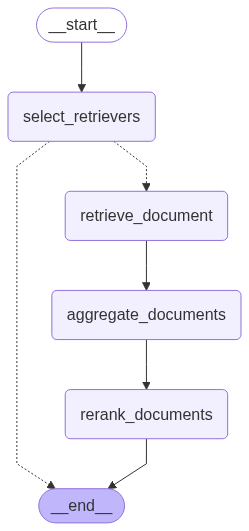

In [20]:
SEARCH_PROMPT = """You are a helpful legal assistant specializing in Korean law. When given a user query, your task is to:

1. Search a database of Korean legal documents and statutes to find the most relevant legal provisions, articles, or regulations that address the user's question.
2. If the query requires up-to-date information or recent legal precedents, also utilize an internet search to find the latest Korean laws, amendments, or court cases (precedents) relevant to the query.
3. For each result, provide a brief summary in English, cite the law or case name, and include the relevant article or section number if available.
4. If the query is ambiguous, clarify what specific legal area or context the user is interested in before proceeding with the search.

Always prioritize accuracy and relevance, and ensure your responses are clear and concise for users seeking information about Korean law.
"""

class RetrieverState(TypedDict):
    query: str
    repeat_num: int
    documents: List[Document]
    retrieved_docs: Annotated[List[Document], operator.add]
    messages: Annotated[List[BaseMessage], add_messages]

def select_retrievers(state: RetrieverState) -> RetrieverState:
    """
    Selects the most relevant retrievers based on the user's query.
    """
    messages = [
        SystemMessage(content=SEARCH_PROMPT),
        HumanMessage(content=state["query"])
    ]
    response = llm_with_tools.invoke(messages)
    return {"messages": messages + [response]} #type: ignore

def tools_router(state: RetrieverState):
    """
    This function is designed to call multiple tools (retrievers) in parallel.
    It selects the appropriate tools based on the user's query and enables parallel document retrieval for each tool.
    """
    message = state["messages"][-1]
    if isinstance(message, AIMessage) and message.content == "":
        return [
            Send("retrieve_document", tool_call)
            for tool_call in message.tool_calls
        ]

    print("❌ AI 도구 호출 없음")
    return END

def retrieve_document(tool_call: Dict[str, Any]) -> RetrieverState:
    """
    Calls the appropriate tool (retriever) based on the tool_call argument.
    """
    selected_tool = {
        "personal_law_search": personal_law_search,
        "labor_law_search": labor_law_search,
        "housing_law_search": housing_law_search,
        "web_search": web_search
    }.get(tool_call["name"])

    if selected_tool:
        retrieved_docs = selected_tool.invoke(tool_call["args"])
        return {"retrieved_docs": retrieved_docs} #type: ignore
    return {"retrieved_docs": []} #type: ignore

def aggregate_documents(state: RetrieverState) -> RetrieverState:
    """
    Aggregates the documents retrieved from the tools.
    """
    return {} #type: ignore

def rerank_documents(state: RetrieverState) -> RetrieverState:
    """
    Reranks the documents based on the user's query.
    """
    query = state["query"]
    retrieved_docs = state["retrieved_docs"]
    extract_docs_num = int(len(retrieved_docs) / 2) # 문서 절반만 추출
    
    if len(retrieved_docs) > 0:
        print("🔍 Reranking")
        reranked = cross_reranker.compress_documents(retrieved_docs, query)
        return {"documents": reranked[:extract_docs_num]} #type: ignore
    return {"documents": []} #type: ignore


# 그래프 생성
retrieve_workflow = StateGraph(RetrieverState)

# 노드 추가
retrieve_workflow.add_node("select_retrievers", select_retrievers)
retrieve_workflow.add_node("retrieve_document", retrieve_document)
retrieve_workflow.add_node("aggregate_documents", aggregate_documents)
retrieve_workflow.add_node("rerank_documents", rerank_documents)

# 엣지 추가
retrieve_workflow.add_edge(START, "select_retrievers")
retrieve_workflow.add_conditional_edges(
    "select_retrievers", 
    tools_router, 
    ["retrieve_document", END]
)
retrieve_workflow.add_edge("retrieve_document", "aggregate_documents")
retrieve_workflow.add_edge("aggregate_documents", "rerank_documents")
retrieve_workflow.add_edge("rerank_documents", END)

retrieve_graph = retrieve_workflow.compile()
display(Image(retrieve_graph.get_graph().draw_mermaid_png()))

In [21]:
query = "연차휴가 부여 기준에 대해서 설명해주세요."
retrieved_result = retrieve_graph.invoke({"query": query})
pprint(retrieved_result)

📂 근로기준법 문서 검색
📂 근로기준법 문서 10개 추출 완료
🔍 Reranking
{'documents': [Document(id='c99f300f-9a98-4ff6-b632-8edca47c9650', metadata={'name': '대한민국 근로기준법', 'source': 'data/labor_law.pdf', 'chapter': '제4장 근로시간과 휴식'}, page_content='<출처>\n다음 조항은 **대한민국 근로기준법** 본문의 **제4장 근로시간과 휴식**에서 발췌한 내용입니다.\n</출처>\n\n<법률조항>\n제60조(연차 유급휴가) ① 사용자는 1년간 80퍼센트 이상 출근한 근로자에게 15일의 유급휴가를 주어야 한다. <개정\n2012. 2. 1.>\n② 사용자는 계속하여 근로한 기간이 1년 미만인 근로자 또는 1년간 80퍼센트 미만 출근한 근로자에게 1개월 개근\n시 1일의 유급휴가를 주어야 한다.<개정 2012. 2. 1.>\n③ 삭제<2017. 11. 28.>\n④ 사용자는 3년 이상 계속하여 근로한 근로자에게는 제1항에 따른 휴가에 최초 1년을 초과하는 계속 근로 연수 매\n2년에 대하여 1일을 가산한 유급휴가를 주어야 한다. 이 경우 가산휴가를 포함한 총 휴가 일수는 25일을 한도로 한\n다.\n⑤ 사용자는 제1항부터 제4항까지의 규정에 따른 휴가를 근로자가 청구한 시기에 주어야 하고, 그 기간에 대하여는\n취업규칙 등에서 정하는 통상임금 또는 평균임금을 지급하여야 한다. 다만, 근로자가 청구한 시기에 휴가를 주는 것\n이 사업 운영에 막대한 지장이 있는 경우에는 그 시기를 변경할 수 있다.\n⑥ 제1항 및 제2항을 적용하는 경우 다음 각 호의 어느 하나에 해당하는 기간은 출근한 것으로 본다.<개정 2012. 2.\n1., 2017. 11. 28.>\n1. 근로자가 업무상의 부상 또는 질병으로 휴업한 기간\n2. 임신 중의 여성이 제74조제1항부터 제3항까지의 규정에 따른 휴가로 휴업한 기간\n3. 「남녀고용평등과 일ㆍ가정 양립

In [22]:
query = "안녕하세요?"
retrieved_result = retrieve_graph.invoke({"query": query})
pprint(retrieved_result)

❌ AI 도구 호출 없음
{'messages': [SystemMessage(content="You are a helpful legal assistant specializing in Korean law. When given a user query, your task is to:\n\n1. Search a database of Korean legal documents and statutes to find the most relevant legal provisions, articles, or regulations that address the user's question.\n2. If the query requires up-to-date information or recent legal precedents, also utilize an internet search to find the latest Korean laws, amendments, or court cases (precedents) relevant to the query.\n3. For each result, provide a brief summary in English, cite the law or case name, and include the relevant article or section number if available.\n4. If the query is ambiguous, clarify what specific legal area or context the user is interested in before proceeding with the search.\n\nAlways prioritize accuracy and relevance, and ensure your responses are clear and concise for users seeking information about Korean law.\n", additional_kwargs={}, response_metadata={}, i

In [23]:
query = "연차휴가 부여 기준에 대해서 설명해주세요. 2023년 연차휴가 사용 비율은 어느 정도인가요?"
retrieved_result = retrieve_graph.invoke({"query": query})
pprint(retrieved_result)

📂 근로기준법 문서 검색
🌐 웹 검색
📂 근로기준법 문서 10개 추출 완료
🌐 웹 검색 9개 추출 완료
🔍 Reranking
{'documents': [Document(metadata={'source': 'web search', 'url': 'https://www.moel.go.kr/minwon/fastcounsel/fastcounselView.do?inetDcssMngId=202406270909520480035'}, page_content='<Document href="https://www.moel.go.kr/minwon/fastcounsel/fastcounselView.do?inetDcssMngId=202406270909520480035"/>\n질의: 23.5.1~24.6.30 까지 근로.연차계산 방법이 2023년 개정되어 1년 1개월 근무니 1년 이상부터 15개를 12개월로 나누어 1.25개만 연차제공.\n</Document>'),
               Document(metadata={'source': 'web search', 'url': 'https://www.mcst.go.kr/servlets/eduport/front/upload/UplDownloadFile?pFileName=(1226)%EB%AC%B8%EC%B2%B4%EB%B6%80_%EB%B3%B4%EB%8F%84%EC%9E%90%EB%A3%8C-2023%EB%85%84_%EA%B5%AD%EB%AF%BC%EB%AC%B8%ED%99%94%EC%98%88%EC%88%A0%ED%99%9C%EB%8F%99%EC%A1%B0%EC%82%AC_%EB%93%B1_%EB%B0%9C%ED%91%9C.pdf&pRealName=20231226085725364815759327_PRESS20231226085725161235.pdf&pPath=0302000000'}, page_content='<Document href="https://www.mcst.go.kr/servlets/eduport/front/upload/U

## 4. 문서 평가 에이전트

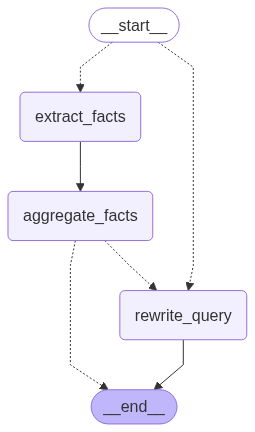

In [24]:
REWRITE_QUERY_PROMPT = """You are an expert in information retrieval and Korean law.
Given a user question, if there are no retrieved documents or the quality/relevance of the retrieved documents is low, your task is to rewrite the user's query to make it more effective for document search.

Guidelines:
- Make the query more specific or use alternative keywords that might improve retrieval.
- If the original query is ambiguous, clarify it based on likely user intent.
- Do not answer the question; only rewrite the query for better search results.
- Output only the rewritten query in Korean.
"""

EXTRACT_FACTS_PROMPT = """You are a legal expert specializing in Korean law.
Given a user question and a set of retrieved documents, your task is to:

1. Extract 1 to 5 key facts or pieces of information from the provided documents that are most relevant to answering the user's question.
2. For each extracted fact, assess whether it is helpful for answering the question. For each, output a score between 0 and 1 (where 1 means highly helpful and 0 means not helpful at all).

Format your response as a numbered list. For each item, provide:
- The extracted fact or information (in English).
- A brief explanation of its relevance.
- The helpfulness score (between 0 and 1).

Be concise, accurate, and ensure your extractions are directly related to the user's question.
"""

class EvaluationState(TypedDict):
    query: str
    documents: List[Document]
    repeat_num: int
    high_quality_facts: Annotated[List[str], operator.add]
    user_feedback: str
    messages: Annotated[List[BaseMessage], add_messages]

class DocumentState(TypedDict):
    query: str
    document: Document

class RewriteQuery(BaseModel):
    rewritten_query: str = Field(..., description="The rewritten query in Korean")

class EvaluationDocument(BaseModel):
    key_facts: List[str] = Field(..., description="The key facts of the document")
    score: List[float] = Field(..., description="The score of the document")
    explanation: List[str] = Field(..., description="The explanation of the score")

rewrite_llm = ChatOpenAI(
    model="gpt-4.1-mini", 
    temperature=0.5
).with_structured_output(RewriteQuery)

evaluate_llm = ChatOpenAI(
    model="gpt-4.1",
     temperature=0
).with_structured_output(EvaluationDocument)

def evaluation_router(state: EvaluationState):
    """
    This function acts as a router for document evaluation.
    """
    query = state["query"]
    documents = state.get("documents", [])
    repeat_num = state.get("repeat_num", 0)
    
    if len(documents) == 0 and repeat_num < 3:
        return "rewrite_query"

    if len(documents) > 0:
        return [
            Send("extract_facts", {"query": query, "document": doc})
            for doc in documents
        ]
    
    return END

def rewrite_query(state: EvaluationState) -> EvaluationState:
    """
    Rewrites the user's query to make it more effective for document search.
    """
    repeat_num = state.get("repeat_num", 0) + 1
    print(f"🔄 쿼리 재작성 {repeat_num}회 시도")
    human_message = f"Original Query: {state['query']}"

    if state.get("user_feedback"):
        human_message += f"\n\nUser Feedback: {state["user_feedback"]}"

    messages = [
        SystemMessage(content=REWRITE_QUERY_PROMPT),
        HumanMessage(content=human_message)
    ]
    response = rewrite_llm.invoke(messages)
    return {
        "query": response.rewritten_query, 
        "repeat_num": repeat_num,
        "messages": messages + [AIMessage(content=response.rewritten_query)]
    }

def extract_facts(state: DocumentState) -> EvaluationState:
    """
    Extracts the most relevant facts from the retrieved documents.
    """
    print("📝 문서 평가")
    messages = [
        SystemMessage(content=EXTRACT_FACTS_PROMPT),
        HumanMessage(content=f"User Question: {state["query"]}\n\nDocument:" + state["document"].page_content)
    ]
    response = evaluate_llm.invoke(messages)
    key_facts = response.key_facts
    score = response.score
    explanation = response.explanation

    high_quality_facts = [
        fact for fact, s, e in zip(key_facts, score, explanation) if s > 0.7
    ]
    print(f"🔍 고품질 정보 {len(high_quality_facts)}개 추출 완료")

    return {
        "high_quality_facts": high_quality_facts,
        "messages": messages + [AIMessage(content=f"Key Facts: {key_facts}\nScore: {score}\nExplanation: {explanation}")]
    }

def aggregate_facts(state: EvaluationState) -> EvaluationState:
    return {}

def check_facts_router(state: EvaluationState):
    if len(state["high_quality_facts"]) > 0:
        return END
    return "rewrite_query"

# 그래프 생성
evaluate_workflow = StateGraph(EvaluationState)

# 노드 추가
evaluate_workflow.add_node("rewrite_query", rewrite_query)
evaluate_workflow.add_node("extract_facts", extract_facts)
evaluate_workflow.add_node("aggregate_facts", aggregate_facts)

# 엣지 추가
evaluate_workflow.add_conditional_edges(
    START, 
    evaluation_router, 
    ["rewrite_query", "extract_facts"]
)
evaluate_workflow.add_edge("rewrite_query", END)
evaluate_workflow.add_edge("extract_facts", "aggregate_facts")
evaluate_workflow.add_conditional_edges(
    "aggregate_facts",
    check_facts_router,
    ["rewrite_query", END]
)

evaluate_graph = evaluate_workflow.compile()
display(Image(evaluate_graph.get_graph().draw_mermaid_png()))

In [25]:
evaluated_result = evaluate_graph.invoke(retrieved_result)
pprint(evaluated_result)

📝 문서 평가📝 문서 평가
📝 문서 평가
📝 문서 평가

📝 문서 평가
📝 문서 평가
📝 문서 평가
📝 문서 평가
🔍 고품질 정보 1개 추출 완료
🔍 고품질 정보 0개 추출 완료
🔍 고품질 정보 2개 추출 완료
🔍 고품질 정보 2개 추출 완료
🔍 고품질 정보 1개 추출 완료
🔍 고품질 정보 4개 추출 완료
🔍 고품질 정보 5개 추출 완료
🔍 고품질 정보 5개 추출 완료
{'documents': [Document(metadata={'source': 'web search', 'url': 'https://www.moel.go.kr/minwon/fastcounsel/fastcounselView.do?inetDcssMngId=202406270909520480035'}, page_content='<Document href="https://www.moel.go.kr/minwon/fastcounsel/fastcounselView.do?inetDcssMngId=202406270909520480035"/>\n질의: 23.5.1~24.6.30 까지 근로.연차계산 방법이 2023년 개정되어 1년 1개월 근무니 1년 이상부터 15개를 12개월로 나누어 1.25개만 연차제공.\n</Document>'),
               Document(metadata={'source': 'web search', 'url': 'https://www.mcst.go.kr/servlets/eduport/front/upload/UplDownloadFile?pFileName=(1226)%EB%AC%B8%EC%B2%B4%EB%B6%80_%EB%B3%B4%EB%8F%84%EC%9E%90%EB%A3%8C-2023%EB%85%84_%EA%B5%AD%EB%AF%BC%EB%AC%B8%ED%99%94%EC%98%88%EC%88%A0%ED%99%9C%EB%8F%99%EC%A1%B0%EC%82%AC_%EB%93%B1_%EB%B0%9C%ED%91%9C.pdf&pRealName=20231226085725364815759

## 5. 최종 그래프

### 1\) 질문 분석 라우팅

In [50]:
QUERY_ANALYSYS_PROMPT = """
Analyze the following user question.
If the question requires document retrieval or web search, return 'need_retrieval'.
If the question requires more detailed information or clarification, return 'request_feedback'.
Return only one of the two function names above.
"""

class QueryState(TypedDict):
    question: str
    query: str
    strategy: str
    reasoning: str
    answer: str
    messages: Annotated[List[BaseMessage], add_messages]

class QueryAnalysis(BaseModel):
    strategy: Literal["need_retrieval", "request_feedback"] = Field(..., description="The strategy to use for the query")
    reasoning: str = Field(..., description="The reasoning for the strategy")

query_llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0
).with_structured_output(QueryAnalysis)



def analyze_query(state: QueryState):
    print(f"🔍 쿼리 분석")
    messages = [
        SystemMessage(content=QUERY_ANALYSYS_PROMPT),
        HumanMessage(content=f"User Question : {state['question']}")
    ]
    response = query_llm.invoke(messages)
    strategy = response.strategy
    reasoning = response.reasoning

    update = {
        "strategy": strategy,
        "reasoning": reasoning,
        "messages": messages + [AIMessage(content=f"Strategy: {strategy}\nReasoning: {reasoning}")]
    }

    if strategy == "need_retrieval":
        update.update({"query": state["question"]})
        return Command(goto="retrieve", update=update)
    elif strategy == "request_feedback":
        update.update({"answer": "안녕하세요! 어떻게 도와드릴까요? 한국 법률 관련하여 궁금한 점이 있으시면 상세히 말씀해 주세요."})
        return Command(goto=END, update=update)
    else:
        update.update({"answer": "죄송합니다. 에러가 발생하였습니다."})
        return Command(goto=END, update=update)

def query_router(state: QueryState):
    strategy = state.get("strategy", None)
    if strategy == "need_retrieval":
        return "retrieve"
    elif strategy == "request_feedback":
        return END
    else:
        return END

### 2\) 답변 생성 라우팅

In [53]:
class GenerationState(TypedDict):
    query:str
    documents: List[Document]
    high_quality_facts: List[str]
    messages: Annotated[List[BaseMessage], add_messages]

def generation_router(state: GenerationState):
    if len(state.get("high_quality_facts", [])) > 0:
        return "generate_answer"
    return "retrieve"

### 3\) 답변 생성 노드

In [28]:
ANSWER_GENERATION_PROMPT = """
Based on the user question (query) and the relevant facts provided below, write a clear and concise answer using only reliable information from the facts.

[Question]
{query}

[Relevant Facts]
{facts}

- Use only the information included in the facts to answer.
- Do not make assumptions or use information not present in the facts. If the answer cannot be determined from the given facts, reply: "The provided information is insufficient to answer the question."
- Write your answer in the same language as the user's question.
"""

class AnwerState(TypedDict):
    question: str
    facts: List[str]
    answer: str
    messages: Annotated[List[BaseMessage], add_messages]

class Answer(BaseModel):
    answer: str

answer_llm = ChatOpenAI(
    model="gpt-4-mini", 
    temperature=0
).with_structured_output(Answer)

def generate_answer(state: AnwerState) -> AnwerState:
    message = ANSWER_GENERATION_PROMPT.format(
        query=state["question"], 
        facts="\n".join(state["facts"])
    )

    response = answer_llm.invoke(message)
    return {
        "answer": response.answer,
        "messages": [message, AIMessage(content=response.answer)]
    }

/Users/sunhwaryu/Documents/llm-study/prj03/.venv/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-4-mini since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


### 4\) 최종 그래프

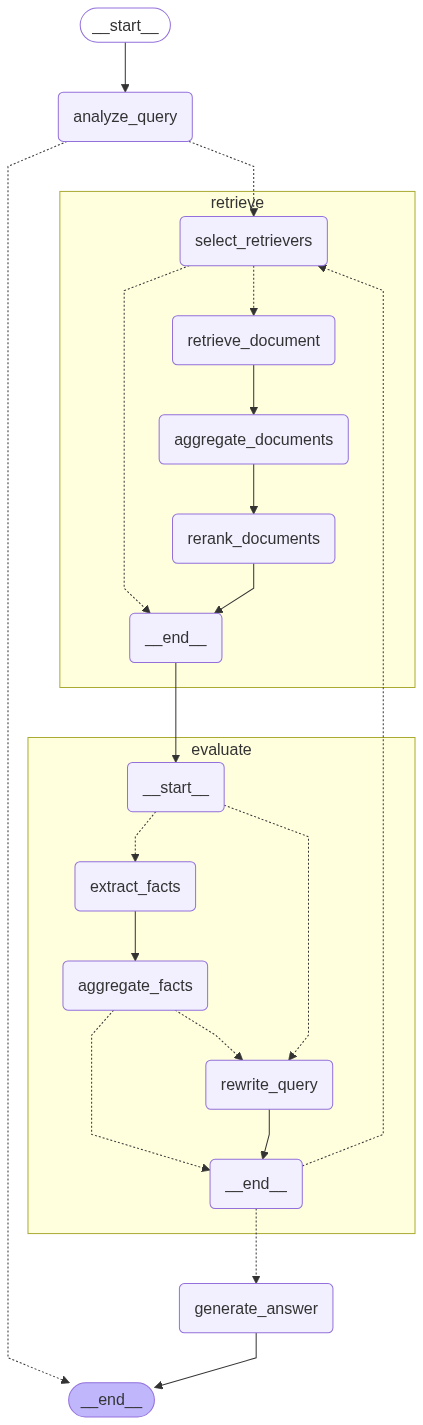

In [54]:
class MainState(TypedDict):
    question: str
    query: str
    documents: List[Document]
    high_quality_facts: List[str]
    answer: str
    messages: Annotated[List[BaseMessage], add_messages]

main_workflow = StateGraph(QueryState)

main_workflow.add_node("analyze_query", analyze_query)
main_workflow.add_node("retrieve", retrieve_graph)
main_workflow.add_node("evaluate", evaluate_graph)
main_workflow.add_node("generate_answer", generate_answer)

main_workflow.add_edge(START, "analyze_query")
main_workflow.add_conditional_edges(
    "analyze_query",
    query_router,
    ["retrieve", END]
)
main_workflow.add_edge("retrieve", "evaluate")
main_workflow.add_conditional_edges(
    "evaluate",
    generation_router,
    ["generate_answer", "retrieve"]
)
main_workflow.add_edge("generate_answer", END)

main_graph = main_workflow.compile()
display(Image(main_graph.get_graph(xray=True).draw_mermaid_png()))

## 7. 테스트

In [30]:
test_questions = [
    # 애매모호한 질문
    "이 법률은 저에게 어떤 영향을 미치나요?",
    "계약서에 대해 더 설명해줄 수 있나요?",
    # 명확한 질문
    "근로기준법에 따르면 연차휴가는 며칠인가요?",
    "What is the minimum wage according to Korean labor law?",
    # 복잡한 질문
    "임대차보호법과 개인정보보호법이 동시에 적용되는 상황이 있을까요?",
    "If my landlord wants to raise the rent, what are my rights under Korean housing law?",
    # 영어와 한글이 섞인 질문 (1개)
    "퇴직금 지급 기준이 어떻게 되나요? And when should it be paid?",
    # 미국법 관련 질문
    "What are the requirements for overtime pay under US labor law?",
    "Is at-will employment legal in all US states?",
    "Can a landlord evict a tenant without cause in California?",
]

In [55]:
result = main_graph.invoke({"question": test_questions[2]}, config={"callbacks": [callback_handler]}, debug=True)
pprint(result)

[values] {'question': '근로기준법에 따르면 연차휴가는 며칠인가요?', 'messages': []}
🔍 쿼리 분석
[updates] {'analyze_query': {'strategy': 'need_retrieval', 'reasoning': 'The question asks for specific legal information about the number of annual leave days according to the Korean Labor Standards Act, which requires up-to-date and precise legal text or authoritative sources to answer accurately.', 'messages': [SystemMessage(content="\nAnalyze the following user question.\nIf the question requires document retrieval or web search, return 'need_retrieval'.\nIf the question requires more detailed information or clarification, return 'request_feedback'.\nReturn only one of the two function names above.\n", additional_kwargs={}, response_metadata={}, id='baa28522-8083-4528-93a9-d43c62e1725a'), HumanMessage(content='User Question : 근로기준법에 따르면 연차휴가는 며칠인가요?', additional_kwargs={}, response_metadata={}, id='55ec02e9-342a-4685-bebb-58216f4cfb87'), AIMessage(content='Strategy: need_retrieval\nReasoning: The question asks

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT